In [10]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import matplotlib.pyplot as plt
import numpy as np

abtem.config.set({"local_diagnostics.progress_bar": False});

# Wave functions
The multislice algorithm works by propagating the $xy$ part of the wave function (defined as $\phi$ in the [appendix](appendix/multislice_derivation.ipynb)) through the electrostatic potential. To initiate this process, we need to assume the initial conditions for the wave function, i.e. the wave function describing the electron beam formed by the electron optics before the sample.

*abTEM* defines three types of wave functions:

* [`PlaneWave`](wave_functions:plane_wave): Simulate HRTEM, SAED or other imaging modes with plane wave illumination.
* [`Probe`](wave_functions:probe): Simulate CBED, STEM or other imaging modes with a converged electron beam.
* [`Waves`](wave_functions:waves): Defines any custom wave function. The `PlaneWave` and `Probe` can be turned into `Waves`.

```{seealso}
The PRISM `SMatrix` is not included in the list above. However, it can be used to achieve most of the goals of using the `Probe`. See our introduction to PRISM in abTEM.
```

(wave_functions:plane_wave)=
## Plane wave functions

We create a plane wave on a $256 \times 256$ grid with a lateral extent of $5\times 5$ $\mathrm{Å}^2$ and an energy of $300 \ \mathrm{keV}$.

In [2]:
plane_wave = abtem.PlaneWave(gpts=256, extent=5, energy=300e3)

The real-space sampling, or pixel size, is calculated by dividing the `extent` by the number of grid points (`gpts`). The properties related to the grid, i.e. the `extent`, `gpts` and `sampling` can be accessed as:

In [3]:
plane_wave.extent, plane_wave.gpts, plane_wave.sampling

((5.0, 5.0), (256, 256), (0.01953125, 0.01953125))

The grid is fully defined from just two of the three quantities listed above, hence, we may pick any combination of two to define the grid. 

The relativistic wavelength in Ångstrom, derived from the energy, is accessed as:

In [4]:
print(f"Wavelength: {plane_wave.wavelength:.4f} Å")

Wavelength: 0.0197 Å


```{note}
*abTEM* uses the same unit conventions as ASE, as defined in the `ase.units` module. Thus, electron volts (eV), Ångström (Å), and atomic mass units are defined as 1.0. The electrostatic potential is given in (eV / e). Angles in *abTEM* are for convenience given in milliradians (mrad).

```
We can turn the `PlaneWave` into the generic `Waves` by using `build`.

In [5]:
waves = plane_wave.build()

waves

-------------------------------------------------

type           label    coordinates
-------------  -------  ------------------
RealSpaceAxis  x [Å]    0.00 0.02 ... 4.98
RealSpaceAxis  y [Å]    0.00 0.02 ... 4.98

        bytes       shape       count     type
------  ----------  ----------  --------  -------------
array   512.00 kiB  (256, 256)  2 tasks   complex64
chunks  512.00 kiB  (256, 256)  1 chunks  numpy.ndarray

The `Waves` describe the wave function as a complex `dask` array accessed below:

In [6]:
waves.array

dask.array<_extract_measurement, shape=(256, 256), dtype=complex64, chunksize=(256, 256), chunktype=numpy.ndarray>

The `Waves` are computed using the `.compute` method, this turns the `dask` array into a `numpy` array. The plane wave is just an array of ones:

In [7]:
waves.compute()

waves.array

array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]],
      dtype=complex64)

```{note}
In the above, the plane wave was normalized to be one in every grid point, i.e. the intensity per area is constant when the grid is changed. This is not always the natural choice, see the [appendix](appendix/normalization.ipynb) for more information on wave function normalization in *abTEM*.
```

(wave_functions:probe)=
## Probe wave functions

In abTEM, a focused beam of electrons, or `Probe`, is defined in Fourier space as

$$
    \hat{\phi}(\vec{k}) = A(\vec{k}) \ \exp(-i \chi(\vec{k})) \quad ,
$$

where $A(k)$ is the aperture function, $\chi(\vec{k})$ is the phase error and $\vec{k} = (k_x, k_y)$ is the spatial frequency in $x$ and $y$, respectively. The real-space probe is just the inverse Fourier transform

$$
    \phi(\vec{r}) = \mathcal{F}^{-1} \left[ \hat{\phi}(\vec{r}) \right] \quad ,
$$

where $\vec{r} = (x, y)$ is the real space coordinate in $x$ and $y$, respectively. The probe wave function is normalized such that its intensity sums to $1$ in Fourier space

$$
    \int \|\hat{\phi}\|^2 d\vec{k} = 1 \quad .
$$


```{seealso}
The contrast transfer function is introduced in detail here.
```

We create a probe with a `sampling` of $0.05 \ \mathrm{Å}$, an `extent` of $10\times 10$ $\mathrm{Å}^2$, an `energy` of $100 \ \mathrm{keV}$, a convergence semiangle (`semiangle_cutoff`) of $30 \ \mathrm{mrad}$ and a `defocus` of $35 \ \mathrm{Å}$. 

In [8]:
probe = abtem.Probe(
    sampling=0.02,
    extent=20,
    energy=80e3,
    semiangle_cutoff=20,
    defocus=-50,
    Cs=-50e-6 * 1e10,
)

## Visualizing the wave function 

To visualize the wave function using *abTEM*'s builtin visualization module, we first have to convert it to a measurement type. The most common methods are `intensity` and `diffraction_patterns`, which will return a measurement as an `Images` and `DiffractionPatterns` type, respectively.

```{seealso}
All the different measurement types implemented in *abtem* are introduced here.
```

The real space intensity (or $\|\phi\|^2$) is calculated and shown below.

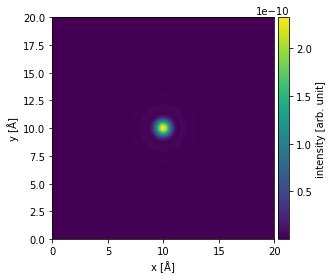

In [11]:
intensity = probe.build().intensity()

intensity.show(cbar=True);

The Fourier-space intensity (or $\|\hat{\phi}\|^2$) is calculated and shown below. We set `max_angle=60` to only include angles up to $60 \ \mathrm{mrad}$.

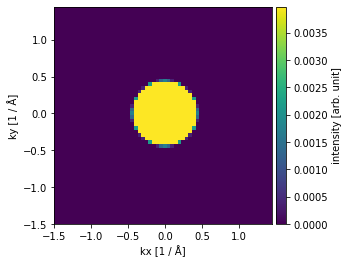

In [10]:
diffraction_patterns = probe.build().diffraction_patterns(max_angle=60)

diffraction_patterns.show(cbar=True);

````{note}
The axes convention for arrays representing a wave functions assigns the first axis to the $x$-axis and the second axis to the $y$-axis, and a larger array index implies a larger real-space coordinate. This is different from the convention often used for images. The correct way of displaying an array with `matplotplib` is given below.
    
```python
import matplotlib.pyplot as plt
image = waves.intensity().array
plt.imshow(image.T, extent=[0, waves.extent[0], 0, waves.extent[1]], origin='lower')
```     
````

Showing a lineprofile sometimes provides a more understable visualization. We use `interpolate_line_at_position` to create a `LineProfile` across the center of the probe intensity.

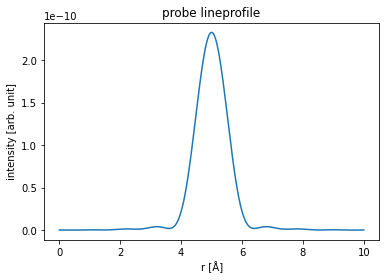

In [11]:
lineprofile = intensity.interpolate_line_at_position(
    center=(10, 10), angle=0, extent=10
)

lineprofile.show(title="probe lineprofile");

It is often useful to know the width of the probe. Below we calculate the width at $0.5$ of the height of the probe (i.e. the full width at half-maximum).

In [12]:
fwhm = lineprofile.width(height=0.5).compute()

print(f"FWHM = {fwhm.item():.2f} Å")

FWHM = 1.16 Å


## Wave function ensembles

In general, the `Waves` represent an ensemble of wave functions as a multidimensional array.  The last two dimensions of the `Waves` represent the spatial dimensions, these are the mandatory or *base* dimensions of the `Waves`. Any preceeding dimensions is an optional *ensemble* dimension. The ensemble dimensions may represent a range of defocii, positions, frozen phonons, tilt and more. `abTEM` will automatically parallelize over the ensemble dimensions. See the [appendix](getting_started:appendix:ensembles) for more details on ensembles in `abTEM`.

As an example, we create an ensemble of probe `Waves` with representing a series of $5$ defocii ranging from $\mathrm{0}$ to $100 \ \mathrm{Å}$.

In [13]:
defocus_series = abtem.distributions.uniform(0, 200, 5)

probe_focal_series = abtem.Probe(
    sampling=0.04,
    extent=20,
    energy=80e3,
    semiangle_cutoff=20,
    defocus=defocus_series,
)

waves_focal_series = probe_focal_series.build()

Inspecting the results, we see that the `Waves` have two base `RealSpaceAxis` and one ensemble `ParameterAxis`.

In [14]:
waves_focal_series

-------------------------------------------------

type           label    coordinates
-------------  -------  ------------------------
ParameterAxis  C10 [Å]  -0.00 -50.00 ... -200.00
RealSpaceAxis  x [Å]    0.00 0.04 ... 19.96
RealSpaceAxis  y [Å]    0.00 0.04 ... 19.96

        bytes     shape          count     type
------  --------  -------------  --------  -------------
array   9.54 MiB  (5, 500, 500)  5 tasks   complex64
chunks  9.54 MiB  (5, 500, 500)  1 chunks  numpy.ndarray

We show an exploded plot of the ensemble below. 

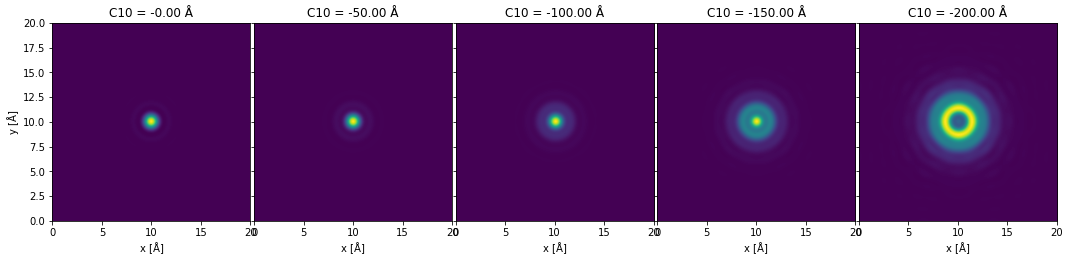

In [15]:
waves_focal_series.intensity().show(
    explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05}
);

````{tip}
If you have [Hyperspy](https://hyperspy.org/) installed, you can view the ensemble interactively by converting the `Images` to a `hyperspy` signal and using the interactive viewer.
```python
waves_focal_series.intensity().to_hyperspy().plot()
```
*Note: This requires using a matplotlib backend that supports interactivity.*
````

line_profiles

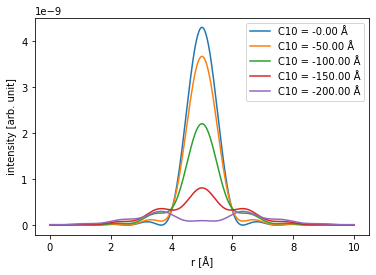

In [16]:
line_profiles = waves_focal_series.intensity().interpolate_line_at_position(
    center=(10, 10), angle=0, extent=10
)

line_profiles.show();

The `Waves` can have any number of ensemble dimensions, for example, we can add two additional axes representing an $x$ and $y$ scan direction as below, thus producing a 3d ensemble of 2d wave functions.

In [17]:
scan = abtem.GridScan()

waves_focal_series_scanned = probe_focal_series.build(scan=scan)

waves_focal_series_scanned

-------------------------------------------------

type           label    coordinates
-------------  -------  ------------------------
ParameterAxis  C10 [Å]  -0.00 -50.00 ... -200.00
ScanAxis       x [Å]    0.00 0.47 ... 19.53
ScanAxis       y [Å]    0.00 0.47 ... 19.53
RealSpaceAxis  x [Å]    0.00 0.04 ... 19.96
RealSpaceAxis  y [Å]    0.00 0.04 ... 19.96

        bytes       shape                  count       type
------  ----------  ---------------------  ----------  -------------
array   17.22 GiB   (5, 43, 43, 500, 500)  497 tasks   complex64
chunks  122.07 MiB  (4, 4, 4, 500, 500)    242 chunks  numpy.ndarray

````{warning}
Be careful when adding ensemble dimensions without also applying a reduction operation, such as taking an ensemble mean or applying a detector. The above wave function ensemble would require $\sim 17 \ \mathrm{GiB}$ of memory to store.

````

## Writing wave functions

As one should expect the wave functions can be written to disk (and read again).

In [24]:
waves_focal_series.to_zarr("./data/exit_waves.zarr", overwrite=True)

imported_wave = abtem.from_zarr("./data/exit_waves.zarr")

assert imported_wave.compute() == waves_focal_series.compute()